<a href="https://colab.research.google.com/github/DrAlexSanz/Real-fake-tweets/blob/master/Data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is only for cleaning the data. The next ones will do more ML related tasks but this only cleans the data thoroughly. I can see that data cleaning is going to be critical in this one.

In [1]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords #This will in the end be set to english and it will be used as a dictionary of stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer#, TfidVectorizer
from sklearn.model_selection import train_test_split #My old friend XD
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix

from collections import defaultdict
from collections import Counter

stop = set(stopwords.words("english"))

import re
import gensim
import string

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Enough with all the imports and dependencies, let's load the data. Now I feel like I'm finally doing something XD.

In [3]:
%cd "/content/drive/My Drive/Tweets"

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

/content/drive/My Drive/Tweets


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


This story is about predicting if the tweets are about a real catastrophe or not (binary classification). Let's see the distribution of labels and hopefully it won't be very skewed. It's a tiny dataset.

In [4]:
train_real = train[train["target"] == 1].shape[0]
train_fake = train[train["target"] == 0].shape[0]

print("there are {} real twits and {} fake twits".format(train_real, train_fake))



there are 3271 real twits and 4342 fake twits


Text(0.5, 1.0, 'Proportion of real and fake twits')

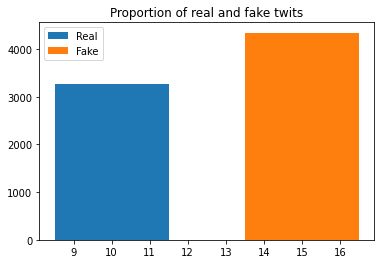

In [5]:
#Now the same but in bars

plt.bar(10, train_real, 3, label = "Real")
plt.bar(15, train_fake, 3, label = "Fake")
plt.legend()
plt.title("Proportion of real and fake twits")

In [0]:
def length(text):
    """Just to calculate length, it's tu use in an apply method. Probably there is a better way to do it
        but I can't think of one right now.
    """
    return len(text)

In [0]:
# I will remove these columns when I save the clean data but it's very useful to explore them.
train["length"] = train["text"].apply(length)
test["length"] = test["text"].apply(length)

Now I want to have a look to see how long are the fake and real tweets. That may be something Lacambra style.

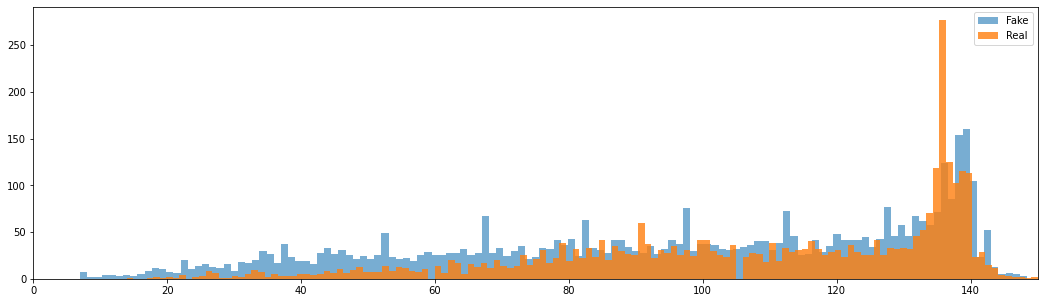

In [8]:
bins = 140 # Twitter has 280 chars, so I will group tweets of 1 and 2, 3 and 4, etc.

plt.rcParams["figure.figsize"] = (18, 5)
plt.hist(train[train["target"] == 0]["length"], alpha = 0.6, bins = bins, label = "Fake"); #Alpha is the transparency
plt.hist(train[train["target"] == 1]["length"], alpha = 0.8, bins = bins, label = "Real");
plt.xlim(0, 150)
plt.legend()
#plt.grid()

This is relatively uninforming but there are less real tweets that are very short. Let's see the length of the tweets in characters. It's not independent of the length but just for completeness.

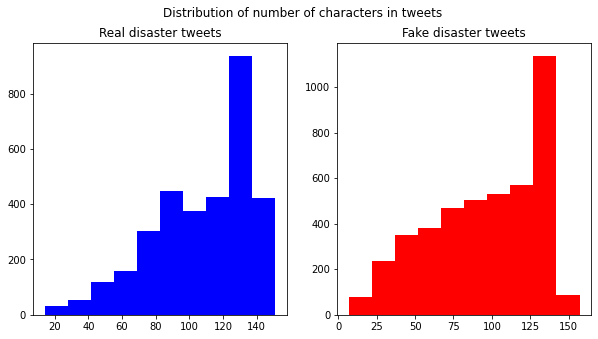

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

real_length = train[train["target"] == 1]["text"].str.len()
ax1.hist(real_length, color = "blue");
ax1.set_title("Real disaster tweets")
fake_length = train[train["target"] == 0]["text"].str.len()
ax2.hist(fake_length, color = "red");
ax2.set_title("Fake disaster tweets")
fig.suptitle("Distribution of number of characters in tweets");



The characters doesn't help. Most tweets are between 120 and 140 characters. But I can see the number of WORDS, not characters. Dimitri from Vladivostok may be lazy and generate always tweets with the same words. I can't see the number of words like that, I'll plot the average word length per tweet. That I can plot.

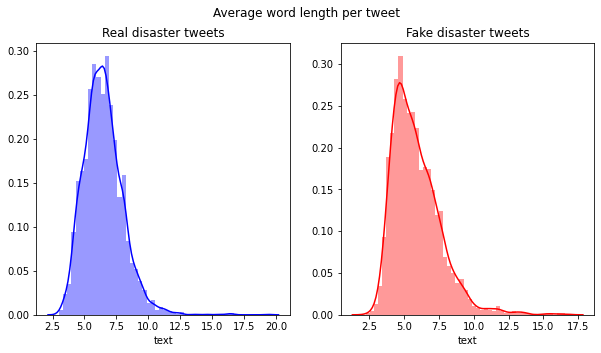

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

word = train[train["target"] == 1]["text"].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax1, color = "blue")
ax1.set_title("Real disaster tweets");

word = train[train["target"] == 0]["text"].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax2, color = "red")
ax2.set_title("Fake disaster tweets");

fig.suptitle("Average word length per tweet");

This doesn't tell me much, the distribution is almost identical. Dimitri has been industrious.

In [0]:
def create_corpus(target):
    
    corpus = []
    
    for x in train[train["target"] == target]["text"].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

In [0]:
def create_corpus_df(df, target):
    
    corpus = []
    
    for x in df[df["target"] == target]["text"].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

Let's focus on the fake tweets first (labeled 0)

In [13]:
#corpus = create_corpus(0)
corups = create_corpus_df(train, 0)
corups[0:10]


["What's", 'up', 'man?', 'I', 'love', 'fruits', 'Summer', 'is', 'lovely', 'My']

This is working ok but I should check the stopwords. First with the fake tweets.

In [14]:
corpus = create_corpus(0)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1 #Skip if it's a stop word

top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[:10]

#The key is the index to sort.
top

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442)]

In [15]:
# and the stopwords are:

np.array(stop)

array({'needn', 'which', 'they', 'this', "should've", 'about', 'itself', 'with', "needn't", "you've", 'doesn', 'am', 'than', 'same', "doesn't", "that'll", 'haven', 'are', 'whom', 'ourselves', 'has', 'below', 'can', 'do', 'who', "you're", 'as', "aren't", "weren't", 'themselves', "she's", 'my', 'y', "hadn't", 'myself', 'just', 'isn', 'until', "mightn't", 'that', 'been', 'after', 'now', 'what', 'ours', 'should', 'couldn', 'she', 'be', 'to', 'being', 'over', 'very', 'an', 'him', 'wouldn', 'under', 'shouldn', 'yours', 'our', 'ma', 'only', 'for', 'down', 'but', 'hasn', 'both', "mustn't", 'any', "it's", 'each', 'weren', 'not', 'yourselves', 'at', 'd', 'during', 'out', 'i', "wouldn't", 'those', 'between', 'why', 'some', 'these', 'll', 'before', 'so', "don't", 'from', 'because', 'there', 'your', 'too', 'if', 'or', 'such', 'yourself', 'no', "haven't", 'through', 'having', 'their', 'was', "isn't", 'wasn', "wasn't", 'is', 'her', 'few', 'nor', 'while', 'had', 'were', "won't", 'have', 'o', 'does', '

Text(0.5, 1.0, 'Most common words in fake tweets')

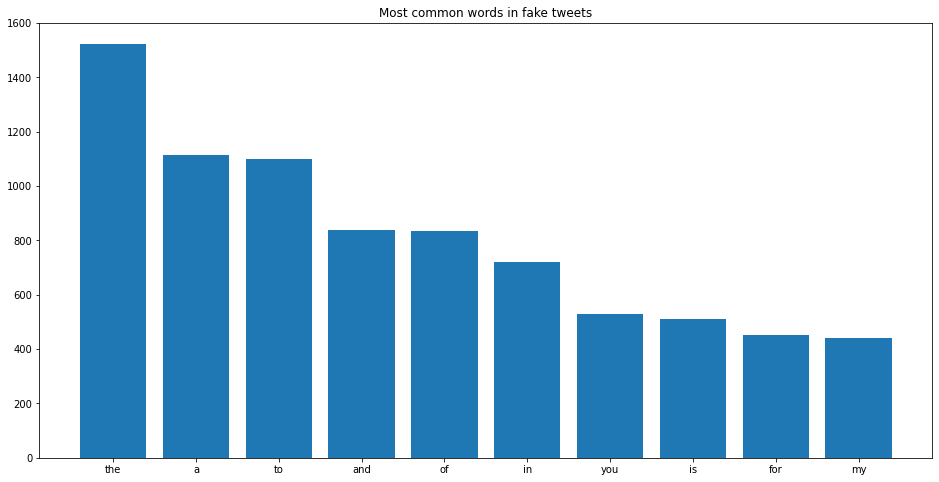

In [16]:
plt.rcParams["figure.figsize"] = (16, 8)

x, y = zip(*top) #This is unzipping the two values for each entry of top

plt.bar(x, y);
plt.title("Most common words in fake tweets")



In [23]:
#Now let's do the same with the other tweets.

corpus = create_corpus(1)

dic = defaultdict(int)

for word in (corpus):
    if word in stop:
        dic[word] += 1 #Skip if it's a stop word

top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[:10]

#The key is the index to sort.
top

[('the', 1051),
 ('in', 1037),
 ('of', 888),
 ('a', 730),
 ('to', 706),
 ('and', 462),
 ('on', 386),
 ('for', 368),
 ('is', 302),
 ('at', 273)]

Text(0.5, 1.0, 'Most common words in fake tweets')

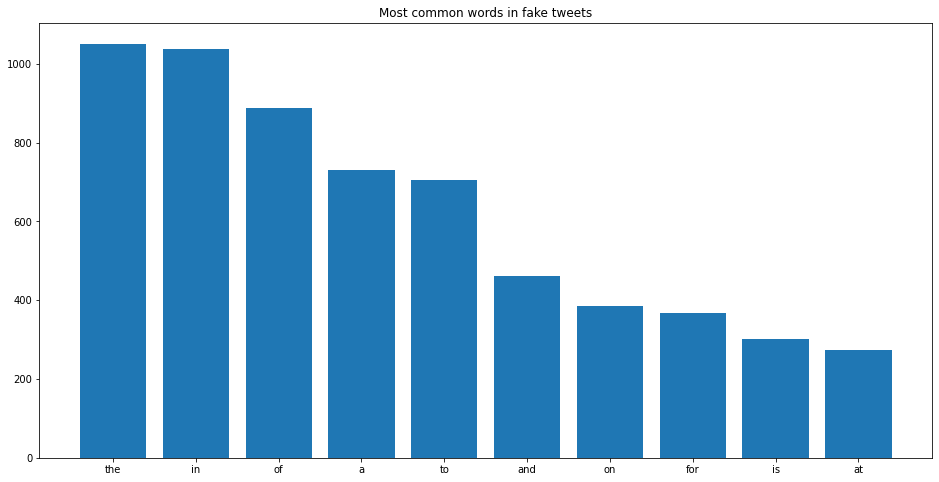

In [18]:
plt.rcParams["figure.figsize"] = (16, 8)

x, y = zip(*top) #This is unzipping the two values for each entry of top

plt.bar(x, y);
plt.title("Most common words in fake tweets")

# Punctuation analysis

The distribution is similar but not the same. Let's see a bit more focusing on punctuation. I'm going to do the same kind of analysis but with the punctuation. Since it's my primerito día with text, I just learnt there is a punctuation method. Mis dieses to these people.

In [26]:
corpus = create_corpus(0) #Start from the fake tweets.

dic = defaultdict(int)

punct = string.punctuation

for i in (corpus):
    if i in punct:
        dic[i] += 1

top = sorted(dic.items(), key = lambda x: x[1], reverse = True)

top

[('-', 374),
 ('|', 91),
 (':', 30),
 ('?', 26),
 ('+', 24),
 ('@', 18),
 ('/', 17),
 ('=', 13),
 ('.', 12),
 ('!', 12),
 ('*', 11),
 ('~', 7),
 ("'", 6),
 ('#', 5),
 ('(', 5),
 (')', 2),
 ('/:', 1),
 ('_', 1),
 ('$', 1),
 ('%', 1)]

Text(0.5, 1.0, 'Punctuation in fake tweets')

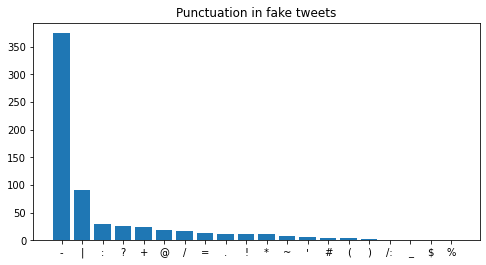

In [28]:
x, y = zip(*top)

plt.figure(figsize = (8, 4))
plt.bar(x, y);
plt.title("Punctuation in fake tweets")


Now the same with real tweets.

In [30]:
corpus = create_corpus(1)

dic = defaultdict(int)

for word in corpus:
    if word in punct:
        dic[word] += 1

top = sorted(dic.items(), key = lambda x: x[1], reverse = True)
top

[('-', 389),
 ('|', 51),
 (':', 31),
 ('/', 18),
 ('~', 14),
 ('?', 11),
 ('@', 9),
 ('.', 7),
 ('+', 7),
 ('!', 6),
 ("'", 5),
 ('=', 4),
 (';', 3),
 ('*', 3),
 ('#', 2),
 (']', 2),
 ('=>', 1),
 (')', 1)]

And we see the numbers are different. That is a good sign that I didn't take the same corpus.

Text(0.5, 1.0, 'Punctuation of real tweets')

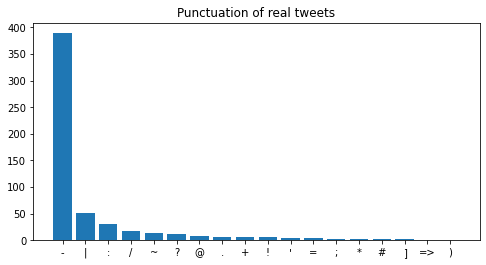

In [32]:
x_1, y_1 = zip(*top)

plt.figure(figsize = (8, 4))

#For side by side bar use seaborn with melt.
plt.bar(x_1, y_1);
plt.title("Punctuation of real tweets")



Let's see the most common words. Not the, a, etc.

In [34]:
corpus = create_corpus(0)

counter = Counter(corpus)
common = counter.most_common()
common[:20] #interesting that the and The are counted as two different words.

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('I', 938),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442),
 ('on', 387),
 ('-', 374),
 ('with', 349),
 ('that', 326),
 ('The', 295),
 ('it', 290),
 ('be', 268),
 ('like', 233),
 ('this', 225)]

In [0]:
x = []
y = []

for word, count in common:
    